
# Research

Installing Packages

In [1]:
!pip install ISLP -q

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.formula.api as smf
from statsmodels.api import OLS
import sklearn.model_selection as skm
import statsmodels.api as sm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
import networkx as nx

In [3]:
!pip install l0bnb -q

In [4]:
from sklearn.pipeline import Pipeline #step-by-step recipe
from sklearn.decomposition import PCA #It reduces the number of features by combining them into new ones (called principal components) that keep the most important information.
from sklearn.cross_decomposition import PLSRegression #Partial Least Squares Regression, selects variables explain variance
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path #does subset selection (finds the path)

In [5]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import graphviz
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [6]:
import warnings
warnings.filterwarnings("ignore")

## Subset Selection Methods
Loading and Cleaning Data

In [7]:
data = pd.read_stata("data.dta")

Explanation of Variables:
- `term1_r2`: **2** | Attendance in R2?
- `T2a`: **1,2,3** | 1, 0
- `T2b`: **1, 2, 3** | 1, 0
- `sample_SG`: **1, 2, 3** | 1, 0 
- `panel`: **1, 2, 3** | 1, 0 
- `eaid`: **1, 2, 3** | EA ID
- `inschool_term1_2009`: **3** | Yes, No
- `inschool_term3_2009`: **3** | Yes
- `num_terms_enrolled`: **3** | Continuous
- `inschool_term2_2008_SS`: **2** | 1, 0
- `inschool_term3_2008_SS`: **2** | 1, 0
- `frac_attend_term1_2009`: **3** | continuous, how many people (divided by what) attended school. lots missing.
- `frac_attend_term2_2009`: **3** | continuous, how many people (divided by what) attended school. lots missing
- `frac_attend_2009_v1`: **3** | continous, what is this? lots of missing data
- `frac_attend_term1_2010`: **3** | continous, what is this? lots of missing data
- `eng_std`: **3** | continuous, std in english scores
- `eng_pilot`: **3** | why is all 0s? 
- `TIMMS_std`: **3** | like math? 
- `math_pilot`: **3** | mostly zeros, being compared to TIMMS_std
- `math_malawi_std`: **3** | math std, compared for pilot as well
- `cog_std`: **3** | cognitive score, continuous 
- `ever_married`: **across 1, 2, 3** | yes, no
- `ever_pregnant`: **across 1, 2, 3** | yes, no 
- `inschool_term1_2010_SS`: **3** | 1, 0 
- `hh_amount`: **1, 2, 3** | missing for so many. household amount (for all siblings)?
- `individual_amount`: **1, 2, 3** | missing for so many (for each student)?
- `total_amount`: **1, 2, 3** | for household, for EA, for what? i think this is not in USD
- `treatment_year3`: **1, 2, 3** | discrete, categorical 
    - treat_ind_amount3=individual_amount if (ea_stat==1 & round==3)
    - cond_treat_ind3 = treat_ind_amount3 * cond_treat_year3;
    - uncond_treat_ind3 = treat_ind_amount3 * uncond_treat_year3;
    - cond_treat_hh3 = treat_hh_amount3 * cond_treat_year3;
    - uncond_treat_hh3 = treat_hh_amount3 * uncond_treat_year3;

Selecting rounds 1 and 3 and only the important variables. Then merging those into one dataframe

In [8]:
data_r1 = data[data['round'] == 1.0]
data_r2 = data[data['round']==2.0]
data_r3 = data[data['round']==3.0]

data_r1 = data_r1[['asset_index_baseline', 'ever_pregnant', 'never_had_sex', 'hhsize', 'female_headed', 
           'highest_grade_baseline', 'father_alive', 'mother_alive', 'age_R1', 'mobile', 
                   'eaid', 'ea_status', 'never_had_sex_baseline', 'cond_treat_year2']].reset_index(drop=True) #group
data_r2 = data_r2[['uncond_treat_year2', 'treatment_year2','asset_index_baseline', 'highest_grade_baseline', 
                   'never_had_sex_baseline']]
data_r3 = data_r3[['asset_index_baseline', 'highest_grade_baseline', 'never_had_sex_baseline',
                   'math_malawi_std', 'eng_std', 'cog_std', 'inschool_term1_2010', 'eaid',
                  'num_terms_enrolled', 'cond_treat_year3', 'uncond_treat_year3', 'treatment_year3',
                   'ever_pregnant', 'ever_married']].reset_index(drop=True)

#joining data
data_r3 = data_r3.rename(columns={'ever_pregnant': 'ever_pregnant_r3', 'ever_married':'ever_married_r3'})
alldata = pd.merge(data_r1, data_r3, on=['eaid','asset_index_baseline', 'highest_grade_baseline', 
                                         'never_had_sex_baseline'], how="inner") #merge for the same people
alldata = pd.merge(alldata, data_r2, on=['asset_index_baseline', 'highest_grade_baseline', 
                                         'never_had_sex_baseline'], how="inner")

Diffs

In [9]:
print(data_r3[data_r3['treatment_year3']==1]['math_malawi_std'].mean() - data_r3[data_r3['treatment_year3']==0]['math_malawi_std'].mean())
print(data_r3[data_r3['treatment_year3']==1]['eng_std'].mean() - data_r3[data_r3['treatment_year3']==0]['eng_std'].mean())
print(data_r3[data_r3['treatment_year3']==1]['cog_std'].mean() - data_r3[data_r3['treatment_year3']==0]['cog_std'].mean())
print(data_r3[data_r3['treatment_year3']==1]['num_terms_enrolled'].mean() - data_r3[data_r3['treatment_year3']==0]['num_terms_enrolled'].mean())

0.02957508
0.025497198
0.0973917
0.635726


In [10]:
# print((data_r1[['asset_index_baseline', 'ever_pregnant', 'highest_grade_baseline', 'age_R1']].describe()).to_latex(caption="Table: Summary Statistics Round 1"))
# print((data_r3[['math_malawi_std', 'eng_std', 'cog_std', 'num_terms_enrolled']].describe()).to_latex(caption="Table: Summary Statistics Round 3"))

Setting string values to 1, 0

In [11]:
def to_01(s: pd.Series, mapping: dict) -> pd.Series:
    # Normalize strings, map to {0,1}, then fall back to numeric, fill NA, cast to int
    s_norm = s.astype(str).str.strip().str.lower()
    mapped = s_norm.map(mapping)
    mapped = mapped.where(~mapped.isna(), pd.to_numeric(s, errors='coerce'))
    return mapped.fillna(0).astype('int8')

for col in ['never_had_sex', 'father_alive', 'mother_alive', 'mobile', 'inschool_term1_2010', 'ever_married_r3']:
    alldata[col] = to_01(alldata[col], {
        'yes':1, 'no':0, 'true':1, 'false':0, 'y':1, 'n':0, '1':1, '0':0
    })
    
for col in ['ea_status']:
    alldata[col] = to_01(alldata[col], {
        'treatment':1, 'treated':1, 'treat':1,
        'control':0, 'ctrl':0, '0':0, '1':1
    })
    
alldata = alldata.dropna()

Subsetting the most important indicators

In [12]:
alldata = alldata[['asset_index_baseline', 'ever_pregnant', 'never_had_sex', 'hhsize', #dummy - remember to exclude
       'female_headed', 'highest_grade_baseline', 'father_alive',
       'mother_alive', 'age_R1', 'mobile', 'ea_status',
       'never_had_sex_baseline', 'math_malawi_std', 'eng_std', 'cog_std',
       'inschool_term1_2010', 'num_terms_enrolled', 'cond_treat_year3',
       'uncond_treat_year3', 'treatment_year3', 'treatment_year2',
       'ever_pregnant_r3', 'ever_married_r3', 'uncond_treat_year2']]

Scaling continuous variables

In [13]:
scale_data = alldata[['asset_index_baseline']]
scaler = MinMaxScaler(feature_range=(0,1))
X1 = scaler.fit_transform(scale_data)
alldata['asset_index_baseline'] = scaler.fit_transform(scale_data)

Interaction Terms

In [14]:
# alldata['ever_pregnant*never_had_sex'] = alldata['ever_pregnant'] * alldata['never_had_sex']
# alldata['treatment_year3*uncond_treat_year3'] = alldata['treatment_year3'] * alldata['uncond_treat_year3']
# alldata['treatment_year3*cond_treat_year3'] = alldata['treatment_year3'] * alldata['cond_treat_year3']
# alldata['treatment_year3*cond_treat_year3*asset_index_baseline'] = alldata['asset_index_baseline'] * alldata['treatment_year3']*alldata['cond_treat_year3']
# alldata['treatment_year3*uncond_treat_year3*asset_index_baseline'] = alldata['asset_index_baseline'] * alldata['treatment_year3']*alldata['uncond_treat_year3']

Yi = α+ β1⋅CCTi + β2⋅UCTi + γ⋅Ai + δ1⋅(CCTi×Ai) + δ2⋅(UCTi×Ai) + Xi⋅θ+ εi

For Treatment i = conditional cash transfers and = unconditional cash transfers
Xi = controls
β3 = how treatment effect changes with income

# 1. OLS Regression - Simple

In [15]:
# alldata = alldata.drop(columns=['cond_treat_year3', 'uncond_treat_year3', 'treatment_year3'])

In [21]:
res = smf.ols(
    formula="""math_malawi_std ~ age_R1 + female_headed + ever_pregnant + never_had_sex
               + father_alive + mother_alive + ea_status + highest_grade_baseline
               + treatment_year3:cond_treat_year3 + treatment_year3:uncond_treat_year3
               + treatment_year3:cond_treat_year3*asset_index_baseline
               + treatment_year3:uncond_treat_year3*asset_index_baseline
               """,
    data=alldata
).fit()
# print(res.summary().as_latex())
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        math_malawi_std   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     225.4
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:20:58   Log-Likelihood:                -5834.7
No. Observations:                4680   AIC:                         1.170e+04
Df Residuals:                    4666   BIC:                         1.179e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -0.8478      0.126     -6.749      0.000      -1.094      -0.602
age_R1                                                     -0.1472      0.008    -19.485      0.000      -0.162      -0.132
female_headed                                               0.1199      0.029      4.089      0.000       0.062       0.177
ever_pregnant                                               0.0591      0.049      1.209      0.227      -0.037       0.155
never_had_sex                                               0.2203      0.034      6.500      0.000       0.154       0.287
father_alive                                                0.0498      0.030      1.674      0.094      -0.009       0.108
mother_alive                                                0.0085      0.033      0.260      0.795      -0.056       0.073
ea_status                                                   0.0953      0.064      1.482      0.139      -0.031       0.221
highest_grade_baseline                                      0.3439      0.008     44.018      0.000       0.329       0.359
treatment_year3:cond_treat_year3                           -0.0836      0.068     -1.234      0.217      -0.216       0.049
treatment_year3:uncond_treat_year3                         -0.0602      0.055     -1.096      0.273      -0.168       0.047
asset_index_baseline                                        0.3907      0.072      5.443      0.000       0.250       0.531
treatment_year3:cond_treat_year3:asset_index_baseline       0.1285      0.113      1.135      0.257      -0.093       0.350
treatment_year3:uncond_treat_year3:asset_index_baseline    -0.0171      0.119     -0.143      0.886      -0.251       0.217
==============================================================================
Omnibus:                       11.664   Durbin-Watson:                   1.408
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.677
Skew:                           0.115   Prob(JB):                      0.00291
Kurtosis:                       3.085   Cond. No.                         217.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Ridge

In [28]:
alldata['treatment_year3*uncond_treat_year3'] = alldata['treatment_year3'] * alldata['uncond_treat_year3']
alldata['treatment_year3*cond_treat_year3'] = alldata['treatment_year3'] * alldata['cond_treat_year3']
alldata['treatment_year3*cond_treat_year3*asset_index_baseline'] = alldata['asset_index_baseline'] * alldata['treatment_year3']*alldata['cond_treat_year3']
alldata['treatment_year3*uncond_treat_year3*asset_index_baseline'] = alldata['asset_index_baseline'] * alldata['treatment_year3']*alldata['uncond_treat_year3']

In [39]:
design = MS(alldata.columns.drop(['math_malawi_std','eng_std','cog_std', 'asset_index_baseline'])).fit(alldata)
Y = np.array(alldata['math_malawi_std'])
X = design.transform(alldata)

In [40]:
D = design.fit_transform(alldata)
D = D.drop('intercept', axis=1)
D = D.dropna()
X = np.asarray(D)

Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs/ X_scale[None,:]
Xs = np.nan_to_num(Xs, nan=0.0)
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

In [41]:
# ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0) #why 59?
scaler = StandardScaler(with_mean=True,  with_std=True)
# pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
param_grid = {'ridge__alpha': lambdas}
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=0)

In [42]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);
pipeCV.fit(X, Y)
tuned_ridge = pipeCV.named_steps['ridge']
tuned_ridge.alpha_

np.float64(0.009310087916685857)

In [43]:
#cv
y_hat = pipeCV.predict(X)
mse_train = mean_squared_error(Y, y_hat)

mean_mse_per_alpha = tuned_ridge.mse_path_.mean(axis=1)
mse_cv = mean_mse_per_alpha.min()     

In [44]:
mse_cv

np.float32(0.6726809)

In [45]:
lambdas, soln_array = skl.ElasticNet.path(Xs,
                                    Y,
                                    l1_ratio=0.,
                                    alphas=lambdas)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

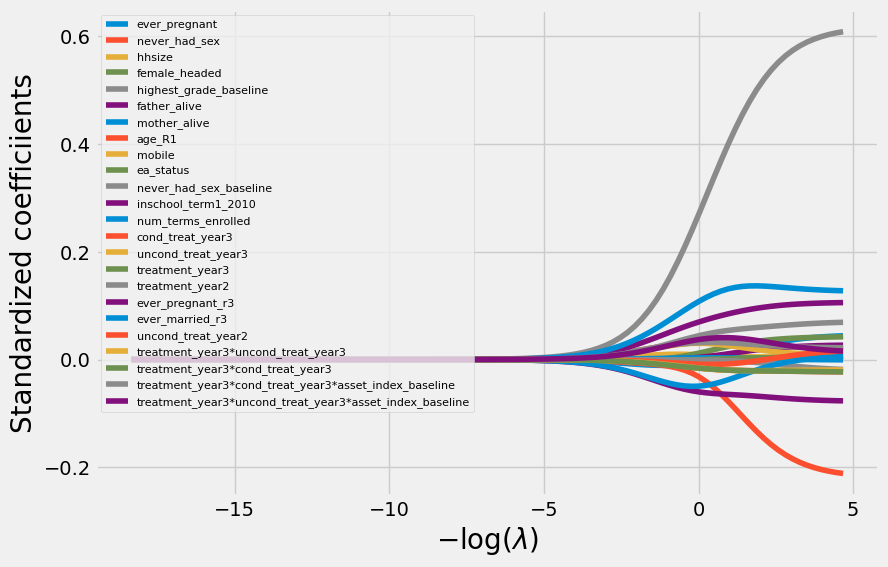

In [46]:
path_fig, ax = subplots(figsize=(9,6))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left', fontsize=8)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [25]:
np.min(tuned_ridge.mse_path_.mean(1))

np.float32(0.5107583)

In [26]:
# beta_hat = soln_path.loc[soln_path.index[-5]]
# lambdas[0], beta_hat

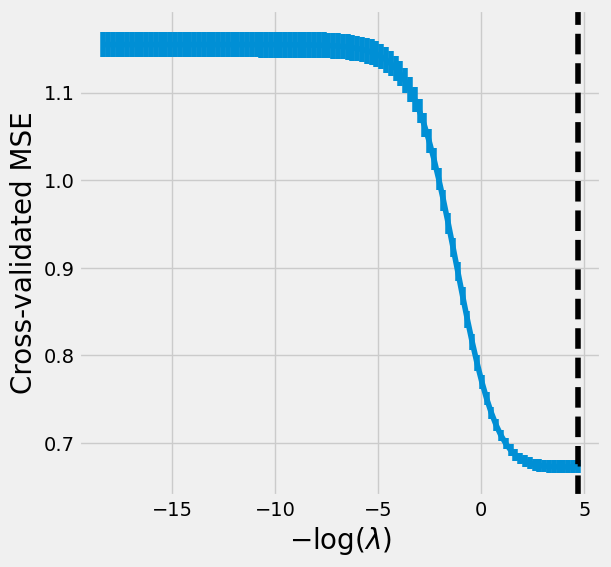

In [47]:
ridgeCV_fig, ax = subplots(figsize=(6,6))
ax.errorbar(-np.log(tuned_ridge.alphas_),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
# ax.set_ylim([0.50,0.58])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

𝜆:

In [48]:
tuned_ridge.alpha_

np.float64(0.009310087916685857)

In [49]:
tuned_ridge.coef_

array([ 4.3973371e-02,  2.1832017e-02,  5.6870701e-03,  4.2022411e-02,
        6.0776895e-01,  2.6602196e-02, -6.0073717e-04, -2.1131638e-01,
        8.7343212e-03,  6.3101221e-03,  2.1831755e-02,  1.0549798e-01,
        1.2743272e-01, -2.2854796e-02, -1.9366352e-02,  6.2932232e-03,
       -1.8434154e-02, -7.6654524e-02,  5.4624686e-03,  1.5937243e-02,
       -1.9371409e-02, -2.2860821e-02,  6.8975240e-02,  1.5663978e-02],
      dtype=float32)

Evaluating Error of Cross-Validated Ridge

In [50]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=0)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=0)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);

In [51]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']

array([0.69245201])

# Lasso

In [52]:
lassoCV = skl.ElasticNetCV(n_alphas=100, #what is n_alphas vs. 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

np.float64(0.0034100834870144483)

In [53]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

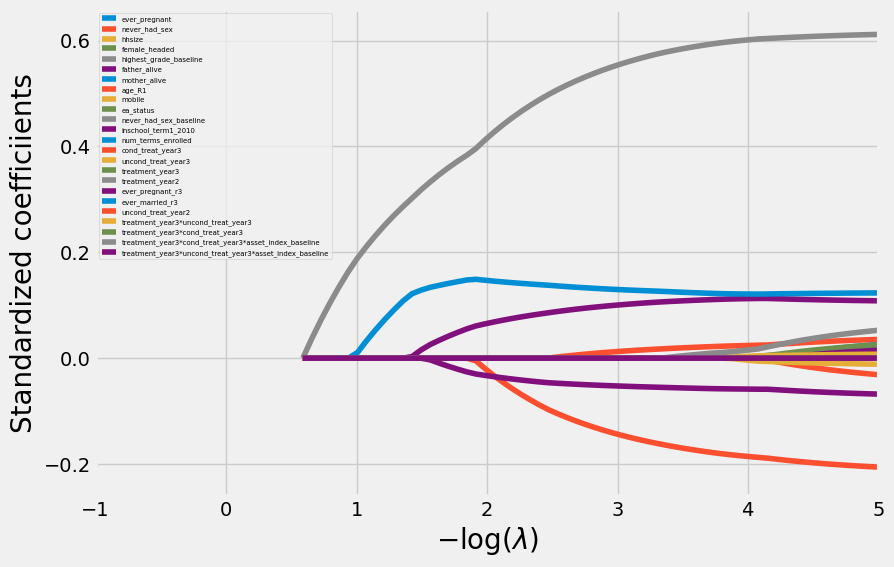

In [54]:
path_fig, ax = subplots(figsize=(9,6))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left', fontsize=5)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_xlim(-1, 5)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [55]:
np.min(tuned_lasso.mse_path_.mean(1))

np.float32(0.67226994)

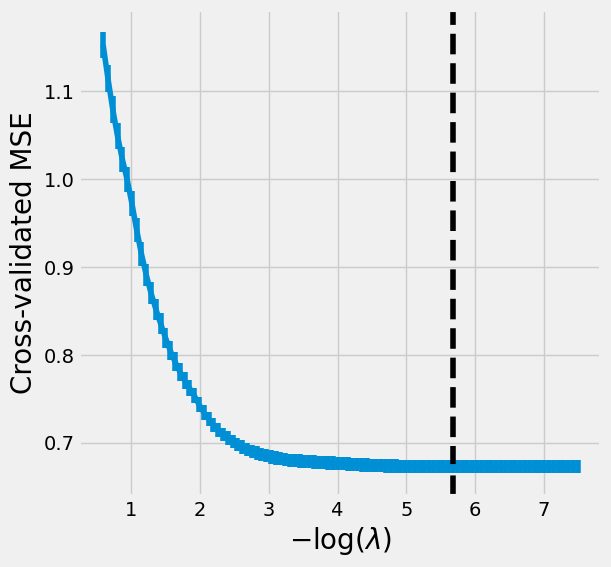

In [56]:
lassoCV_fig, ax = subplots(figsize=(6,6))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
# ax.set_ylim([0.50,0.58])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

𝜆:

In [57]:
tuned_lasso.alpha_

np.float64(0.0034100834870144483)

In [58]:
tuned_lasso.coef_

array([ 0.03534392,  0.0380435 ,  0.00280316,  0.03389645,  0.61403984,
        0.02098362, -0.        , -0.21220824,  0.00765529, -0.        ,
        0.00085087,  0.10653718,  0.12394515, -0.0360776 , -0.01862442,
       -0.        , -0.00364475, -0.07130542, -0.        ,  0.        ,
       -0.        , -0.        ,  0.05989848,  0.00835741], dtype=float32)

Evaluating Error of Cross-Validated Lasso

In [59]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=0)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=0)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=1,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)]);

In [60]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')


# 2. Regression Tree

Dummies

In [ ]:
alldata = pd.get_dummies(alldata, columns = ['hhsize', 'highest_grade_baseline', 'age_R1'], 
                         drop_first=False)

In [ ]:
# alldata['ever_pregnant*never_had_sex'] = alldata['ever_pregnant'] * alldata['never_had_sex']
alldata['treatment_year3*uncond_treat_year3'] = alldata['treatment_year3'] * alldata['uncond_treat_year3']
alldata['treatment_year3*cond_treat_year3'] = alldata['treatment_year3'] * alldata['cond_treat_year3']
alldata['treatment*cond*asset_index_baseline'] = alldata['asset_index_baseline'] * alldata['treatment_year3']*alldata['cond_treat_year3']
alldata['treatment*uncond*asset_index_baseline'] = alldata['asset_index_baseline'] * alldata['treatment_year3']*alldata['uncond_treat_year3']

In [ ]:
X = alldata.drop(columns=['math_malawi_std', 'eng_std', 'cog_std', 'inschool_term1_2010', 'num_terms_enrolled', 'treatment_year3', 'uncond_treat_year3', 'cond_treat_year3'])
X = sm.add_constant(X)   
y = alldata['eng_std']

In [ ]:
High = np.where(alldata['eng_std'] > alldata['eng_std'].mean(),
                "Yes",
                "No")

model = MS(X.columns, intercept=False)
D = model.fit_transform(X)
feature_names = list(D.columns)
X = np.asarray(D)

In [ ]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                alldata['eng_std'],
                                test_size=0.3,
                                random_state=0)

In [ ]:
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)        
clf.fit(X, High)

reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(10,6))[1]
plot_tree(reg,
          feature_names=feature_names,
          fontsize=7, 
          ax=ax);

In [ ]:
accuracy_score(High, clf.predict(X))

In [ ]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)
best_ = grid.best_estimator_
treemse = np.mean((y_test - best_.predict(X_test))**2)

# 3. Bagging

In [ ]:
bag_data = RF(max_features=X_train.shape[1], random_state=0)
bag_data.fit(X_train, y_train)

CV

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
mse_scores = cross_val_score(
    bag_data, X_train, y_train,
    cv=cv, scoring="neg_mean_squared_error", n_jobs=-1
)
mse_scores = (-mse_scores)

print("CV MSE: " , (mse_scores.mean()))
bag_cv_mse = mse_scores.mean()

bag_data.fit(X_train, y_train)

In [ ]:
ax = subplots(figsize=(2,2))[1]
y_hat_bag = bag_data.predict(X_test)
ax.scatter(y_hat_bag, y_test)
bagmse = np.mean((y_test - y_hat_bag)**2) #MSE

# 4. RF

CV 

In [ ]:
param_grid = {
    "n_estimators": [50, 100, 250],
    "max_features": [4, 6, 8, 10],
    "max_depth": [None, 10, 20],
}
gs = GridSearchCV(
    RF(max_features=X_train.shape[1], bootstrap=True, random_state=0),
    param_grid, cv=5, scoring="neg_mean_squared_error"
)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV MSE:", (gs.best_score_))

In [ ]:
rf_best = gs.best_estimator_
y_pred = rf_best.predict(X_test)
print("Test RMSE:", (mean_squared_error(y_test, y_pred)))

rf_cv_mse = gs.best_score_
rf_test_mse = (mean_squared_error(y_test, y_pred))

In [ ]:
feature_imp = pd.DataFrame(
    {'importance': rf_best.feature_importances_},
    index=feature_names)
# print(feature_imp.sort_values(by='importance', ascending=False).head(10).to_latex(caption="Variable Importance"))

# 5. Boosting

In [ ]:
gbr = GBR(
    random_state=0,
    n_iter_no_change=20, 
    validation_fraction=0.1 
)

param_grid = {
    "learning_rate":  [0.001, 0.05],
    "n_estimators":   [100, 250, 500],
    "max_depth":      [2, 3, 4],
    "subsample":      [1.0, 0.7],
    "max_features":   [None, "sqrt"]
}

cv = KFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=cv,
    refit=True,
    verbose=0
)

gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV MSE:", (gs.best_score_))

gbr_best = gs.best_estimator_
y_pred = gbr_best.predict(X_test)
print("Test RMSE:", (mean_squared_error(y_test, y_pred)))

boost_cv_mse = gs.best_score_
boost_test_mse = (mean_squared_error(y_test, y_pred))

### Error Comparisons

In [ ]:
pd.DataFrame([treemse, bag_cv_mse, rf_test_mse, boost_test_mse],
             ['Regression Tree', 'Bagging', 'Random Forest', 'Boosting']
             ).rename(columns={0:'MSE'})

# 8. DAG Graphs

In [67]:
# Define the graph
sample_gml = """graph [
directed 1

node [
    id 0
    label "CCT"
    ]

node [
    id 1
    label "UCT"
    ]
node [
    id 2
    label "Test Scores"
    ]
node [
    id 3
    label "Asset Index"
    ]
node [
    id 4
    label "Age"
    ]  
node [
    id 5
    label "Married"
    ]  
node [
    id 6
    label "Pregnant"
    ]  
node [
    id 7
    label "Grade"
    ]    

edge [
    source 0
    target 2
    ]
edge [
    source 1
    target 2
    ]
edge [
    source 3
    target 1
    ]
edge [
    source 3
    target 0
    ]
edge [
    source 4
    target 2
    ]
edge [
    source 5
    target 2
    ]
edge [
    source 6
    target 2
    ]
edge [
    source 7
    target 2
    ]
]
    
    """

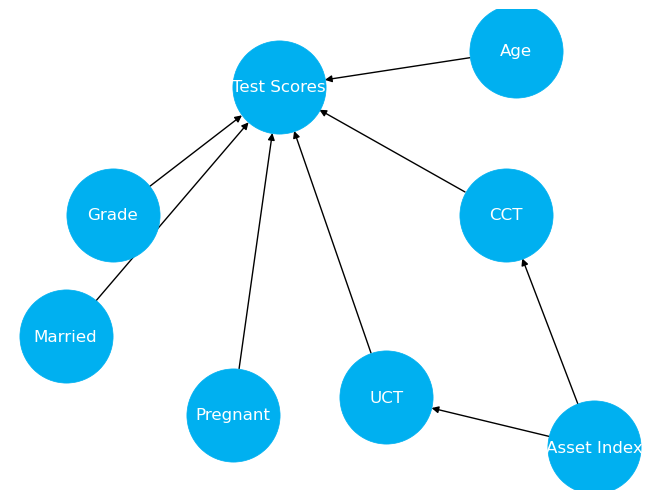

In [68]:
# Get the graph
graph = nx.parse_gml(sample_gml)

# Plot
nx.draw(
    G=graph, 
    with_labels=True,
    node_size=4500,
    node_color=COLORS[0],
    font_color='white'
)